In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from tqdm import tqdm
import json
import math
import glob
from numpy.typing import ArrayLike

In [2]:
np.random.seed(2424)

In [3]:
puyo_files = sorted(glob.glob("images/puyo/*.png"))
puyo_files = [f for f in puyo_files if "_cvd" not in f]
print(puyo_files)

['images/puyo\\puyo_aqua.png', 'images/puyo\\puyo_beta.png', 'images/puyo\\puyo_block.png', 'images/puyo\\puyo_capsule.png', 'images/puyo\\puyo_classic.png', 'images/puyo\\puyo_degi.png', 'images/puyo\\puyo_fever.png', 'images/puyo\\puyo_gamegear.png', 'images/puyo\\puyo_gummy.png', 'images/puyo\\puyo_human.png', 'images/puyo\\puyo_moji.png', 'images/puyo\\puyo_moro.png', 'images/puyo\\puyo_msx.png', 'images/puyo\\puyo_shiki.png', 'images/puyo\\puyo_sonic.png', 'images/puyo\\puyo_tetris.png']


In [4]:
# Set image paths
bg_files = sorted(glob.glob("./images/char-bgs/*/*.png"))
puyo_files = sorted(glob.glob("images/puyo/*.png"))

# For now, exclude CVD Puyo Skins until I learn how to simulate the Daltonzation on them
puyo_files = sorted(glob.glob("images/puyo/*.png"))
puyo_files = [f for f in puyo_files if "_cvd" not in f]

# Get all characters in 1P-facing orientation
bg_images = [np.array(Image.open(f).crop((8, 2, 392, 722)).resize((98, 180))) for f in tqdm(bg_files)]
# Include characters in flipped 2P-facing orientation
bg_images += [np.array(Image.open(f).crop((8, 2, 392, 722)).transpose(Image.FLIP_LEFT_RIGHT).resize((98, 180))) for f in tqdm(bg_files)]
puyo_skins = [np.array(Image.open(f).resize((512, 256))) for f in tqdm(puyo_files)]

100%|██████████| 16/16 [00:02<00:00,  7.36it/s]


Dimensions of a character background:  (180, 98, 4)


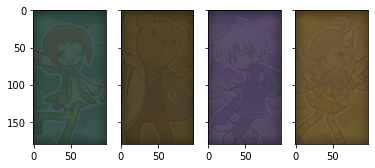

In [5]:
print("Dimensions of a character background: ", bg_images[0].shape)
fig, ax = plt.subplots(1, 4, sharey=True)
for i, j in enumerate(np.random.choice(len(bg_images), 4, replace=False)):
    ax[i].imshow(bg_images[j])
plt.show()

Dimensions of a puyo skin file:  (256, 512, 4)


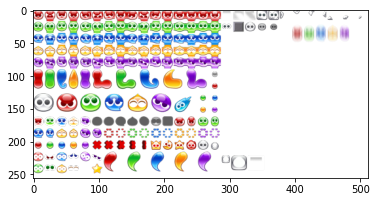

In [6]:
print("Dimensions of a puyo skin file: ", puyo_skins[8].shape)
plt.imshow(puyo_skins[8])
plt.show()

## Helper Functions

In [7]:
# The character backgrounds and puyo spritesheets are downscaled to 25% of original size.
# Char BG: 384x720 -> 98x180
# Puyo BG: 2048x1024 -> 512x256
UNIT_W = 18
UNIT_H = 18
PUYO_W = 16
PUYO_H = 15

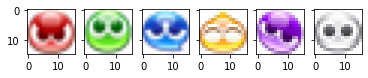

In [8]:
def get_garbage_puyos(puyo_skin: np.ndarray):
    puyos = []
    y0, y1 = 18, 18 + PUYO_H
    for x in np.arange(18 * UNIT_W, 21 * UNIT_W, UNIT_W):
        x0, x1 = x, x + PUYO_W
        puyos.append(puyo_skin[y0:y1, x0:x1, :])
    return puyos

def get_colored_puyos(puyo_skin: np.ndarray):
    puyos = []
    for y in range(0, UNIT_H * 5, UNIT_H):
        y0, y1 = y, y + PUYO_H
        color = []
        for x in np.arange(0, UNIT_W * 16, UNIT_W):
            x0, x1 = x, x + PUYO_W
            color.append(puyo_skin[y0:y1, x0:x1, :])
        puyos.append(color)
    return puyos

def get_cropped_puyos(puyo_skin: np.ndarray):
    puyos = []
    puyos += get_colored_puyos(puyo_skin)
    puyos += [get_garbage_puyos(puyo_skin)]
    return puyos

puyos = get_cropped_puyos(puyo_skins[8])
fig, ax = plt.subplots(1, 6, sharey=True)
for i in range(len(puyos)):
    ax[i].imshow(puyos[i][0])
plt.show()

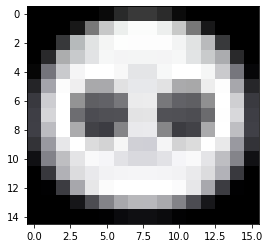

In [9]:
def alpha_blend(bg: np.ndarray, top: np.ndarray):
    '''
    https://en.wikipedia.org/wiki/Alpha_compositing#Alpha_blending
    '''
    # Get the two layers as float images
    bg = bg.astype(np.double) / 255.0
    top = top.astype(np.double) / 255.0

    # Spread the alpha value into its own 3-channel array, so the
    # subsequent RGB channels matches with the right percentage
    a = top[:, :, 3]
    a = a[:, :, np.newaxis] * np.array([1, 1, 1])
    
    top_rgb = top[:, :, :3]

    return np.array((top_rgb * a + bg[:, :, :3] * (1 - a)) * 255, dtype=np.uint8)

test_bg = np.ones((PUYO_H, PUYO_W, 4), dtype=np.uint8) * np.array([0, 0, 0, 255])
test_im = puyos[5][0]
im_a = alpha_blend(test_bg, test_im)
plt.imshow(im_a)
plt.show()

In [10]:
def get_board_cells(char_bg: np.ndarray):
    data = char_bg.reshape(-1, 4)
    cells = []

    for y in range(12):
        for x in range(6):
            x0, x1 = PUYO_W * x, PUYO_W * (x + 1)
            y0, y1 = PUYO_H * y, PUYO_H * (y + 1)
            cell = char_bg[y0:y1, x0:x1]
            cells.append(cell[..., :3])
    
    return np.array(cells)

cells = get_board_cells(bg_images[0])
print(cells.shape)


(72, 15, 16, 3)


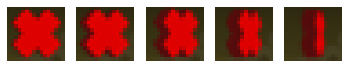

In [11]:
def get_Xes(cell: np.ndarray, puyo_skin: np.ndarray):
    # Get the spinning X
    y0, y1 = UNIT_H * 11, UNIT_H * 11 + PUYO_H
    spinning_Xes = []
    for x in np.arange(5 * UNIT_W, 10 * UNIT_W, UNIT_W):
        x0, x1 = x, x + PUYO_W
        spinning_Xes.append(puyo_skin[y0:y1, x0:x1, :])
    
    cells = []
    for spinner in spinning_Xes:
        cells.append(alpha_blend(cell, spinner))
    
    return cells

cells = get_board_cells(bg_images[0])
Xes = get_Xes(cells[2], puyo_skins[8])
fig, ax = plt.subplots(1, len(Xes))
for x in range(len(Xes)):
    ax[x].imshow(Xes[x])
    ax[x].axis('off')
plt.show()

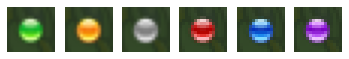

In [12]:
def get_dots(cell: np.ndarray, puyo_skin: np.ndarray):
    dots = []
    # Get the dots
    x0, x1 = UNIT_W * 14, UNIT_W * 14 + PUYO_W
    for y in np.arange(7 * UNIT_H, 9 * UNIT_H, UNIT_H):
        y0, y1 = y, y + PUYO_H
        dots.append(puyo_skin[y0:y1, x0:x1, :])
    
    x0, x1 = UNIT_W * 15, UNIT_W * 15 + PUYO_W
    for y in np.arange(5 * UNIT_H, 9 * UNIT_H, UNIT_H):
        y0, y1 = y, y + PUYO_H
        dots.append(puyo_skin[y0:y1, x0:x1, :])
    
    cells = []
    for dot in dots:
        cells.append(alpha_blend(cell, dot))
    return cells

cells = get_board_cells(bg_images[1])
dots = get_dots(cells[39], puyo_skins[8])
fig, ax = plt.subplots(1, len(dots))
for x in range(len(dots)):
    ax[x].imshow(dots[x])
    ax[x].axis('off')
plt.show()

## Generate "None"

- 138 char bgs
- 5 possible X icons
- 6 possible dots that should be ignored
- 5 different types of X: degi, human, msx, gamegear, and aqua/gummy/the rest.
- 71 possible empty cells for each character

In [13]:
for i, name in enumerate(puyo_files):
    print(i, name)

0 images/puyo\puyo_aqua.png
1 images/puyo\puyo_beta.png
2 images/puyo\puyo_block.png
3 images/puyo\puyo_capsule.png
4 images/puyo\puyo_classic.png
5 images/puyo\puyo_degi.png
6 images/puyo\puyo_fever.png
7 images/puyo\puyo_gamegear.png
8 images/puyo\puyo_gummy.png
9 images/puyo\puyo_human.png
10 images/puyo\puyo_moji.png
11 images/puyo\puyo_moro.png
12 images/puyo\puyo_msx.png
13 images/puyo\puyo_shiki.png
14 images/puyo\puyo_sonic.png
15 images/puyo\puyo_tetris.png


In [14]:
skin_subset = [puyo_skins[i] for i in [0, 5, 9, 12, 7]]

# For each character, get empty cells
empty_cells = []
for bg in bg_images:
    cells = get_board_cells(bg)
    # Don't include the cell where the X should be
    cells = cells[np.arange(0, 72) != 2]
    for cell in cells:
        empty_cells.append(cell)
print("Empty cells for each character: ", len(empty_cells))

# For each character, get X cells
x_cells = []
for bg in bg_images:
    cells = get_board_cells(bg)
    cell = cells[2]
    for puyo_skin in skin_subset:
        Xes = get_Xes(cell, puyo_skin)
        for X in Xes:
            x_cells.append(X)
print("X cells for each character background: ", len(x_cells))

# For each character, get dots
dot_cells = []
for bg in bg_images:
    cells = get_board_cells(bg)
    inds = np.random.choice(72, 5, replace=False)
    cell = cells[39]
    for puyo_skin in puyo_skins:
        dots = get_dots(cell, puyo_skin)
        for dot in dots:
            dot_cells.append(dot)
print("Dot cells for each character background: ", len(dot_cells))

none_cells = np.array(empty_cells + x_cells + dot_cells)
print(none_cells.shape)

Empty cells for each character:  9798
X cells for each character background:  3450
Dot cells for each character background:  13248
(26496, 15, 16, 3)


## Generate Colored Puyos
Need to boost Sonic, MSX, and Human to improve their purple/green detection

In [15]:
aug_puyo_skins = [
    *puyo_skins,
    puyo_skins[14], # Sonic
    puyo_skins[12], # MSX
    puyo_skins[9] # Human
]

puyos = np.array([get_colored_puyos(skin) for skin in aug_puyo_skins])
# Put the color category as the first dim
puyos = puyos.transpose((1, 0, 2, 3, 4, 5))
# puyos.shape -> (19, 5, 16, 15, 16, 4)

# Combine 16 orientations for each Puyo in each skin (19+)
puyos = puyos.reshape((5, -1, PUYO_H, PUYO_W, 4))
print(puyos.shape)

(5, 304, 15, 16, 4)


In [16]:
for i, name in enumerate(bg_files):
    print(i, name)

0 ./images/char-bgs\esports\field_alx.png
1 ./images/char-bgs\esports\field_aly.png
2 ./images/char-bgs\esports\field_ami.png
3 ./images/char-bgs\esports\field_arl.png
4 ./images/char-bgs\esports\field_car.png
5 ./images/char-bgs\esports\field_cie.png
6 ./images/char-bgs\esports\field_dra.png
7 ./images/char-bgs\esports\field_hed.png
8 ./images/char-bgs\esports\field_hra.png
9 ./images/char-bgs\esports\field_hrp.png
10 ./images/char-bgs\esports\field_htm.png
11 ./images/char-bgs\esports\field_lgn.png
12 ./images/char-bgs\esports\field_mag.png
13 ./images/char-bgs\esports\field_raf.png
14 ./images/char-bgs\esports\field_ris.png
15 ./images/char-bgs\esports\field_rng.png
16 ./images/char-bgs\esports\field_rng_2p.png
17 ./images/char-bgs\esports\field_rul.png
18 ./images/char-bgs\esports\field_sat.png
19 ./images/char-bgs\esports\field_shz.png
20 ./images/char-bgs\esports\field_sig.png
21 ./images/char-bgs\esports\field_sig_2p.png
22 ./images/char-bgs\esports\field_srr.png
23 ./images/cha

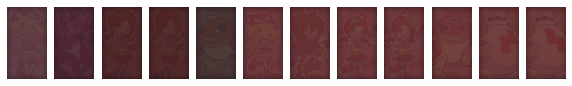

In [17]:
red_chars = np.array([bg_images[i] for i in [2, 7, 15, 16, 24, 28, 30, 40, 41, 50, 65, 66]])
fig, ax = plt.subplots(1, len(red_chars))
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(len(red_chars)):
    ax[i].imshow(red_chars[i])
    ax[i].axis('off')
plt.show()

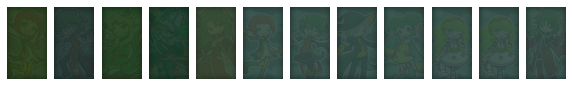

In [18]:
green_chars = np.array([bg_images[i] for i in [1, 6, 8, 10, 18, 27, 32, 34, 38, 61, 62, 63]])
fig, ax = plt.subplots(1, len(green_chars))
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(len(green_chars)):
    ax[i].imshow(green_chars[i])
    ax[i].axis("off")
plt.show()

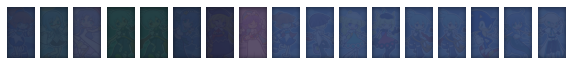

In [19]:
blue_chars = np.array([bg_images[i] for i in [3, 5, 17, 20, 21, 22, 25, 26, 29, 35, 36, 37, 44, 45, 47, 49, 54]])
fig, ax = plt.subplots(1, len(blue_chars))
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(len(blue_chars)):
    ax[i].imshow(blue_chars[i])
    ax[i].axis("off")
plt.show()

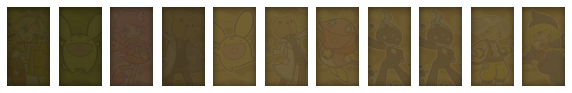

In [20]:
yellow_chars = np.array([bg_images[i] for i in [0, 4, 13, 14, 31, 39, 46, 51, 52, 57, 67]])
fig, ax = plt.subplots(1, len(yellow_chars))
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(len(yellow_chars)):
    ax[i].imshow(yellow_chars[i])
    ax[i].axis("off")
plt.show()

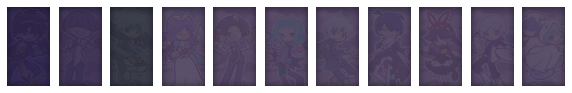

In [21]:
purple_chars = np.array([bg_images[i] for i in [11, 12, 19, 26, 33, 42, 43, 48, 53, 64, 68]])
fig, ax = plt.subplots(1, len(purple_chars))
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(len(purple_chars)):
    ax[i].imshow(purple_chars[i])
    ax[i].axis("off")
plt.show()

In [22]:
mean_colors = [np.mean(chars[..., :3].reshape((-1, 3)), axis=0) for chars in [red_chars, green_chars, blue_chars, yellow_chars, purple_chars]]
mean_colors = np.array(mean_colors, dtype=np.uint8)
for n, c in zip(['red\t', 'green\t', 'blue\t', 'yellow\t', 'purple\t'], mean_colors):
    print(n, c)

red	 [92 49 51]
green	 [49 71 59]
blue	 [50 65 93]
yellow	 [90 74 42]
purple	 [72 62 89]


In [23]:
# Get all Puyos overlayed on each color
puyo_with_bg = []
for color in puyos:
    color_set = []
    for mean_bg in mean_colors:
        flat_bg = np.ones((PUYO_H, PUYO_W, 3)) * mean_bg
        for puyo in color:
            color_set.append(alpha_blend(flat_bg, puyo))
    puyo_with_bg.append(color_set)
puyo_with_bg = np.array(puyo_with_bg)
print(puyo_with_bg.shape)

(5, 1520, 15, 16, 3)


In [24]:
# Get Garbage Puyos overlayed on each color
garbage_puyos = []

for mean_bg in mean_colors:
    flat_bg = np.ones((PUYO_H, PUYO_W, 3)) * mean_bg
    for skin in puyo_skins:
        g_puyos = get_garbage_puyos(skin)
        blends = [alpha_blend(flat_bg, g_puyo) for g_puyo in g_puyos]
        for blend in blends:
            garbage_puyos.append(blend)

garbage_puyos = np.array(garbage_puyos)
print(garbage_puyos.shape)
print(len(puyo_skins))

(240, 15, 16, 3)
16


## Summary of Puyo Counts so far

In [25]:
print('Empty cell:\t', none_cells.shape[0])
print('Garbage Puyo:\t', garbage_puyos.shape[0])
print('Colored Puyos (each):\t', puyo_with_bg.shape[1])
print('Colored Puyos (total):\t', puyo_with_bg.shape[0] * puyo_with_bg.shape[1])

Empty cell:	 26496
Garbage Puyo:	 240
Colored Puyos (each):	 1520
Colored Puyos (total):	 7600


## Torchvision Augmentations

In [26]:
from torchvision import transforms

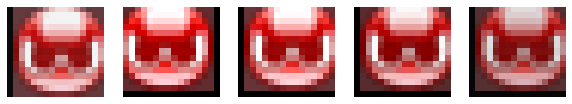

In [27]:
torch_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(0, (0.1, 0.1)),
    transforms.ColorJitter(0.1, 0.1, 0.1)
])

def apply_transform(im: np.ndarray) -> np.ndarray:
    im = torch_transforms(im)
    im = np.array(im)
    return im


fig, ax = plt.subplots(1, 5)
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(5):
    test_red = apply_transform(puyo_with_bg[0][0])
    ax[i].imshow(test_red)
    ax[i].axis("off")
plt.show()

### None cells

In [28]:
transformed_empty = []

for i in range(2):
    for p in tqdm(range(none_cells.shape[0])):
        new_cell = apply_transform(empty_cells[0])
        transformed_empty.append(new_cell)

transformed_empty = np.array(transformed_empty)
print(transformed_empty.shape)

100%|██████████| 26496/26496 [00:20<00:00, 1321.10it/s](52992, 15, 16, 3)



In [29]:
print(none_cells.shape)
print(transformed_empty.shape)
all_none = np.concatenate([none_cells, transformed_empty], axis=0)
print(all_none.shape)

(26496, 15, 16, 3)
(52992, 15, 16, 3)
(79488, 15, 16, 3)


### Colored Puyos

In [30]:
transformed_puyos = [[], [], [], [], []]
for i in tqdm(range(51)):
    for c in range(5):
        color_set = []
        for p in range(puyo_with_bg.shape[1]):
            new_puyo = apply_transform(puyo_with_bg[c][p])
            color_set.append(new_puyo)
        transformed_puyos[c] += color_set

transformed_puyos = np.array(transformed_puyos)
print(transformed_puyos.shape)

100%|██████████| 51/51 [04:29<00:00,  5.29s/it]
(5, 77520, 15, 16, 3)


In [31]:
print(puyo_with_bg.shape)
print(transformed_puyos.shape)
all_puyos = np.concatenate([puyo_with_bg, transformed_puyos], axis=1)
print(all_puyos.shape)

(5, 1520, 15, 16, 3)
(5, 77520, 15, 16, 3)
(5, 79040, 15, 16, 3)


### Garbage Puyos

In [32]:
garbage_puyos.shape

(240, 15, 16, 3)

In [33]:
transformed_garbage = []

for i in tqdm(range(331)):
    for p in range(garbage_puyos.shape[0]):
        new_garbage = apply_transform(garbage_puyos[p])
        transformed_garbage.append(new_garbage)

transformed_garbage = np.array(transformed_garbage)
print(transformed_garbage.shape)

100%|██████████| 331/331 [00:57<00:00,  5.76it/s]
(79440, 15, 16, 3)


In [34]:
print(garbage_puyos.shape)
print(transformed_garbage.shape)
all_garbage = np.concatenate([garbage_puyos, transformed_garbage], axis=0)
print(all_garbage.shape)

(240, 15, 16, 3)
(79440, 15, 16, 3)
(79680, 15, 16, 3)


In [35]:
# Subset empty cells
inds = np.arange(all_none.shape[0])
need_count = all_puyos.shape[1]
sub_inds = np.random.choice(inds, need_count, replace=True)
all_none = all_none[sub_inds]
print("None: ", all_none.shape)

# Subset garbage Puyos
inds = np.arange(all_garbage.shape[0])
need_count = all_puyos.shape[1]
sub_inds = np.random.choice(inds, need_count, replace=True)
all_garbage = all_garbage[sub_inds]
print("Garbage: ", all_garbage.shape)

None:  (79040, 15, 16, 3)
Garbage:  (79040, 15, 16, 3)


In [36]:
print("Final Counts")
print("Colored Puyos (each): ", all_puyos.shape[1])
print("Garbage Puyos: ", all_garbage.shape[0])
print("Empty Cells: ", all_none.shape[0])

Final Counts
Colored Puyos (each):  79040
Garbage Puyos:  79040
Empty Cells:  79040


## Rearrange numpy data to be compatible with PyTorch tensors later

In [37]:
# 0 = empty, 1 = garbage, 2, 3, 4, 5, 6 = rgbyp
labels = [0] * all_none.shape[0]
labels += [1] * all_garbage.shape[0]
for i in range(2, 7):
    labels += [i] * all_puyos[i - 2].shape[0]
print(len(labels))

553280


In [38]:
X = np.concatenate([all_none, all_garbage, *all_puyos], axis=0)
print(X.shape)

(553280, 15, 16, 3)


In [39]:
y = np.array(labels)
y.shape

(553280,)

In [40]:
import joblib
joblib.dump(X, "dataset-images.joblib")
joblib.dump(y, "dataset-labels.joblib")

['dataset-labels.joblib']

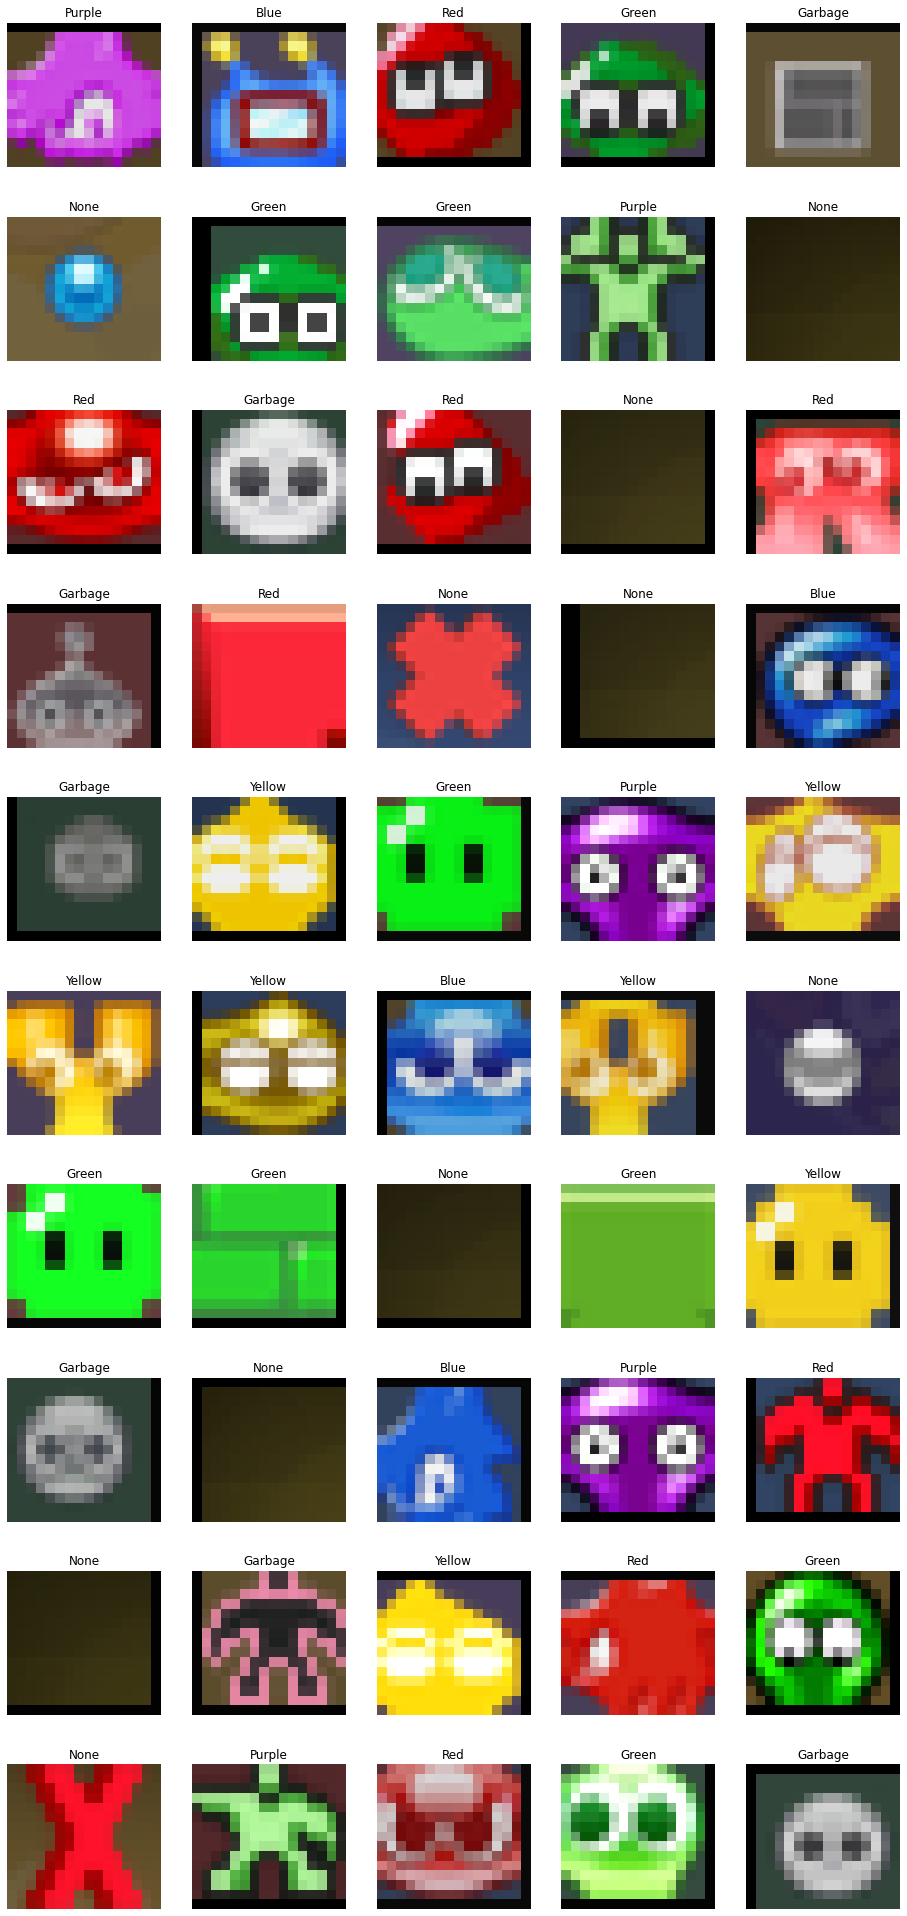

In [41]:
fig, ax = plt.subplots(10, 5)
fig.set_figheight(35)
fig.set_figwidth(16)
names = ["None", "Garbage", "Red", "Green", "Blue", "Yellow", "Purple"]
for i in range(10):
    for j in range(5):
        ind = np.random.choice(X.shape[0])
        lab = y[ind]
        name = names[lab]
        ax[i][j].imshow(X[ind])
        ax[i][j].set_title(name)
        ax[i][j].axis("off")
plt.show()